# Sanity Check of FedLeak (Resize Generator), ImageNet(ISLVRC2012).

Here is the sanity check on if FedLeak has been correctly trasferred.

We evaluate it with ***ImageNet(ISLVRC2012)***, with $5$ times sampling batch = $16$, reporting results in $5$ times recovery.
- *Evaluate times*: $5$.
- *Attack Target*: the averaged gradient from a sampled batch with $16$ datapoints.
- *How to sample*: the first $5$ batches from test-set, with `shuffle=True`.
- *Way to report*: PSNRs in $5$ times recovery, including the *max* value and the *median* value.

Codes are aligned with `sanity_check_resize_showcase.ipynb`, with `resize_generator.py` introduced.

### 🚩 1. Utils Importing

In [1]:
import warnings
warnings.filterwarnings("ignore")

import torch, torchvision, argparse, os
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt

try:
    import utils
    from criteria import *
    from utils import upscale, get_resnet18
    from resize_generator import FedLeak
except ModuleNotFoundError:
    # You only really need this safety net if you want to run these notebooks directly in the examples directory
    # Don't worry about this if you installed the package or moved the notebook to the main directory.
    os.chdir("..")
    
    import utils
    from criteria import *
    from utils import upscale, get_resnet18
    from resize_generator import FedLeak


def plot_images(images):
    plt.figure(figsize=(4, 3))
    
    images = images.clone().detach()
    images.mul(255).add_(0.5).clamp_(0, 255)
    images = images.to(dtype=torch.float32)

    grid_shape = int(torch.as_tensor(images.shape[0]).sqrt().ceil())
    _, axes = plt.subplots(grid_shape, grid_shape, figsize=(6, 6))
    for im, axis in zip(images, axes.flatten()):
        axis.imshow(im.permute(1, 2, 0).cpu())
        axis.axis("off")

    plt.show()


class ImageNet(torch.utils.data.Dataset):
    def __init__(self, dir="./imagenet/images", csv_path="./imagenet/images.csv", transforms=None):
        self.dir = dir
        self.csv = pd.read_csv(csv_path)
        self.transforms = transforms

    def __getitem__(self, index):
        img_obj = self.csv.loc[index]
        ImageID = img_obj['ImageId'] + '.png'
        Truelabel = img_obj['TrueLabel'] - 1
        img_path = os.path.join(self.dir, ImageID)
        pil_img = Image.open(img_path).convert('RGB')
        if self.transforms:
            data = self.transforms(pil_img)
        return data, Truelabel

    def __len__(self):
        return len(self.csv)

class NormalizedModel(torch.nn.Module):
    def __init__(self, model, mean, std, device):
        super(NormalizedModel, self).__init__()
        self.model = model
        self.resize_op = torchvision.transforms.Resize((224, 224))
        self.mean, self.std = mean.to(device), std.to(device)

    def forward(self, x):
        x = self.resize_op(x)
        x = (x - self.mean) / self.std
        return self.model(x)


def get_client_gradient(data, label, model, loss_fn):
    loss = loss_fn(model(data), label)
    grads = torch.autograd.grad(loss, model.parameters())
    return grads


@torch.jit.script
def l1_loss(x, y):
    return (x-y).abs().mean()


def l2_loss(x, y):
    return (x-y).norm(2)


@torch.jit.script
def cos_loss(x, y):
    mask = x.abs().detach() >= x.detach().flatten().abs().quantile(0.2).item() # 只保留最小的百分之多少
    x, y = x * mask, y * mask
    return -(x.flatten() * y.flatten()).sum() / (x.flatten().norm(2)+1e-8) / (y.flatten().norm(2)+1e-8)


@torch.jit.script
def combine_loss(x, y):
    mask = (y.abs() >= torch.quantile(y.abs(), 0.5).item()).float()
    x, y = mask * x, mask * y
    return l1_loss(x, y) + cos_loss(x, y)

### 🚩 2. Data Loading

In [2]:
seed = 2025
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
device = torch.device(f"cuda:3")
transform = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Resize((128, 128))
])

dataset = torchvision.datasets.ImageNet(root="~/data/imagenet/", split="val", transform=transform)
trainloader = torch.utils.data.DataLoader(dataset, batch_size=16, shuffle=True, generator=torch.Generator().manual_seed(seed))
loader_iter = iter(trainloader)

device

device(type='cuda', index=3)

### 🚩 3. Attack for five times

In [3]:
# define utils
import statistics
def print_psnrs(psnrs):
    median_psnr = statistics.mean(psnrs)
    best_psnr = max(psnrs)
    print(f"BEST PSNR: {best_psnr:6.4f}")
    print(f"MEDIAN PSNR: {median_psnr:6.4f}")
    
    print("ALL PSNR: [", end="")
    for p in psnrs[0:-1]:
        print(f"{p:6.4f}, ", end="")
    print(f"{p:6.4f}]")

#### ⭕ 3.1 Times 1

True Data:


<Figure size 400x300 with 0 Axes>

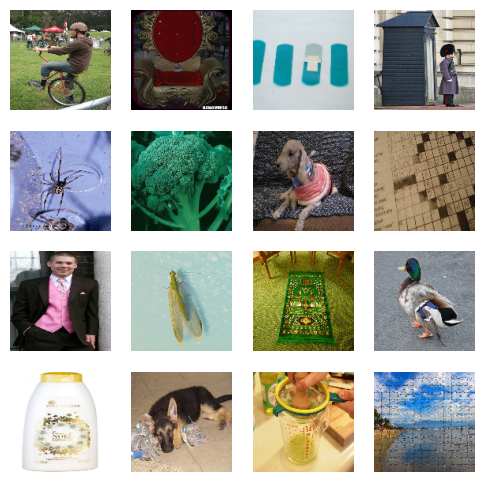

| It: 1 | Loss: -13.7063 | Time:   5.02s |


| It: 1001 | Loss: -61.1623 | Time: 469.35s |


| It: 2001 | Loss: -61.6470 | Time: 469.85s |


| It: 3001 | Loss: -61.7742 | Time: 469.03s |


| It: 4001 | Loss: -61.8371 | Time: 469.63s |


| It: 5001 | Loss: -61.8792 | Time: 469.95s |


| It: 6001 | Loss: -61.9118 | Time: 468.64s |


| It: 7001 | Loss: -61.9351 | Time: 469.88s |


| It: 8001 | Loss: -61.9495 | Time: 468.82s |


| It: 9001 | Loss: -61.9562 | Time: 469.45s |


| It: 1 | Loss: -3.7202 | Time:   0.53s |


| It: 1001 | Loss: -61.0697 | Time: 468.82s |


| It: 2001 | Loss: -61.6282 | Time: 468.36s |


| It: 3001 | Loss: -61.7686 | Time: 469.44s |


| It: 4001 | Loss: -61.8352 | Time: 470.10s |


| It: 5001 | Loss: -61.8801 | Time: 470.57s |


| It: 6001 | Loss: -61.9109 | Time: 469.10s |


| It: 7001 | Loss: -61.9355 | Time: 468.87s |


| It: 8001 | Loss: -61.9496 | Time: 467.34s |


| It: 9001 | Loss: -61.9562 | Time: 467.33s |


| It: 1 | Loss: -0.0445 | Time:   0.38s |


| It: 1001 | Loss: -60.9956 | Time: 468.12s |


| It: 2001 | Loss: -61.6180 | Time: 468.50s |


| It: 3001 | Loss: -61.7606 | Time: 469.20s |


| It: 4001 | Loss: -61.8317 | Time: 466.96s |


| It: 5001 | Loss: -61.8763 | Time: 468.54s |


| It: 6001 | Loss: -61.9108 | Time: 468.89s |


| It: 7001 | Loss: -61.9339 | Time: 469.53s |


| It: 8001 | Loss: -61.9487 | Time: 542.08s |


| It: 9001 | Loss: -61.9555 | Time: 565.58s |


| It: 1 | Loss: -8.7326 | Time:   0.62s |


| It: 1001 | Loss: -61.1365 | Time: 564.14s |


| It: 2001 | Loss: -61.6490 | Time: 562.96s |


| It: 3001 | Loss: -61.7819 | Time: 566.04s |


| It: 4001 | Loss: -61.8429 | Time: 563.95s |


| It: 5001 | Loss: -61.8848 | Time: 564.20s |


| It: 6001 | Loss: -61.9155 | Time: 563.89s |


| It: 7001 | Loss: -61.9378 | Time: 565.32s |


| It: 8001 | Loss: -61.9519 | Time: 565.04s |


| It: 9001 | Loss: -61.9579 | Time: 561.43s |


| It: 1 | Loss: -10.2113 | Time:   0.47s |


| It: 1001 | Loss: -61.0772 | Time: 561.70s |


| It: 2001 | Loss: -61.6459 | Time: 561.81s |


| It: 3001 | Loss: -61.7795 | Time: 563.63s |


| It: 4001 | Loss: -61.8418 | Time: 562.23s |


| It: 5001 | Loss: -61.8868 | Time: 562.42s |


| It: 6001 | Loss: -61.9183 | Time: 563.53s |


| It: 7001 | Loss: -61.9399 | Time: 562.26s |


| It: 8001 | Loss: -61.9537 | Time: 564.06s |


| It: 9001 | Loss: -61.9599 | Time: 564.15s |


BEST PSNR: 20.7765
MEDIAN PSNR: 20.4802
ALL PSNR: [20.3890, 20.3526, 20.2300, 20.6529, 20.6529]


<Figure size 400x300 with 0 Axes>

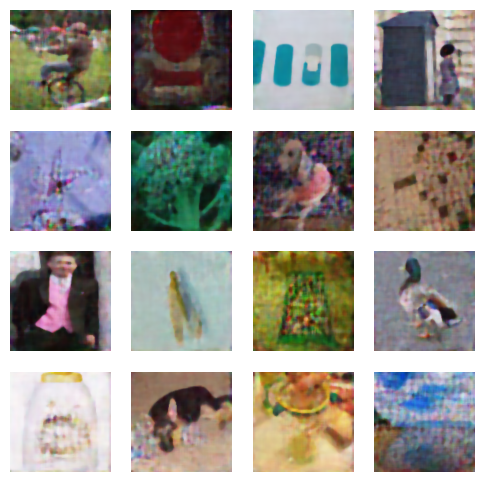

In [4]:
model = get_resnet18().to(device)
loss_func = torch.nn.CrossEntropyLoss()
data, label = next(loader_iter)
data, label = data.to(device), label.to(device)
client_grads = get_client_gradient(data, label, model, torch.nn.CrossEntropyLoss())
client_grads = [grad.clone() for grad in client_grads]
print(f"True Data:")
plot_images(data)

data = upscale(data)
best_ones_PSNR = torch.zeros_like(data)
best_ones_SSIM = torch.zeros_like(data)
best_ones_LPIPS = torch.zeros_like(data)
psnrs = []

for _ in range(5): # restart for better attack performance.
    recovered_images = FedLeak(client_grads, label, model, combine_loss, device=device)
    psnr = compute_psnr(data, recovered_images, False).mean().item()
    psnrs.append(psnr)
    best_ones_PSNR = update_best_ones(best_ones_PSNR, data, recovered_images, "PSNR")

print_psnrs(psnrs)
plot_images(best_ones_PSNR)

#### ⭕ 3.2 Times 2

True Data:


<Figure size 400x300 with 0 Axes>

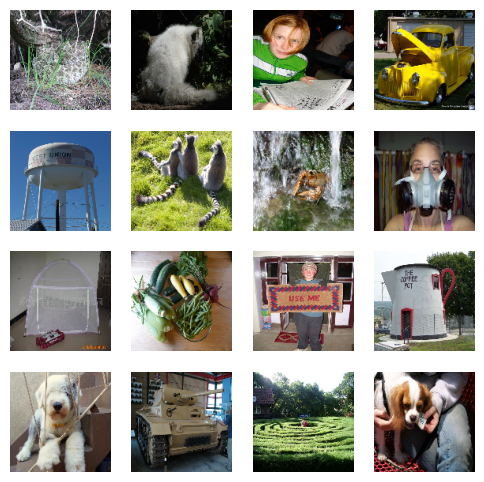

| It: 1 | Loss: -5.6931 | Time:   0.52s |


| It: 1001 | Loss: -61.1378 | Time: 562.43s |


| It: 2001 | Loss: -61.6606 | Time: 562.02s |


| It: 3001 | Loss: -61.7911 | Time: 562.95s |


| It: 4001 | Loss: -61.8498 | Time: 559.49s |


| It: 5001 | Loss: -61.8918 | Time: 560.91s |


| It: 6001 | Loss: -61.9224 | Time: 563.85s |


| It: 7001 | Loss: -61.9451 | Time: 564.90s |


| It: 8001 | Loss: -61.9581 | Time: 559.79s |


| It: 9001 | Loss: -61.9640 | Time: 563.33s |


| It: 1 | Loss: -9.2432 | Time:   0.42s |


| It: 1001 | Loss: -60.9457 | Time: 565.60s |


| It: 2001 | Loss: -61.6251 | Time: 565.27s |


| It: 3001 | Loss: -61.7640 | Time: 560.83s |


| It: 4001 | Loss: -61.8388 | Time: 564.12s |


| It: 5001 | Loss: -61.8836 | Time: 560.73s |


| It: 6001 | Loss: -61.9156 | Time: 563.99s |


| It: 7001 | Loss: -61.9394 | Time: 565.74s |


| It: 8001 | Loss: -61.9538 | Time: 564.07s |


| It: 9001 | Loss: -61.9605 | Time: 563.08s |


| It: 1 | Loss: -7.9588 | Time:   0.45s |


| It: 1001 | Loss: -61.1907 | Time: 565.37s |


| It: 2001 | Loss: -61.6629 | Time: 565.11s |


| It: 3001 | Loss: -61.7886 | Time: 564.47s |


| It: 4001 | Loss: -61.8506 | Time: 562.60s |


| It: 5001 | Loss: -61.8916 | Time: 563.66s |


| It: 6001 | Loss: -61.9232 | Time: 565.44s |


| It: 7001 | Loss: -61.9445 | Time: 562.78s |


| It: 8001 | Loss: -61.9581 | Time: 564.01s |


| It: 9001 | Loss: -61.9638 | Time: 561.53s |


| It: 1 | Loss: -12.5411 | Time:   0.46s |


| It: 1001 | Loss: -60.6614 | Time: 564.49s |


| It: 2001 | Loss: -61.5614 | Time: 563.88s |


| It: 3001 | Loss: -61.7351 | Time: 564.06s |


| It: 4001 | Loss: -61.8181 | Time: 564.54s |


| It: 5001 | Loss: -61.8693 | Time: 564.97s |


| It: 6001 | Loss: -61.9079 | Time: 563.80s |


| It: 7001 | Loss: -61.9337 | Time: 409.34s |


| It: 8001 | Loss: -61.9497 | Time: 352.73s |


| It: 9001 | Loss: -61.9566 | Time: 344.22s |


| It: 1 | Loss: -5.6377 | Time:   0.37s |


| It: 1001 | Loss: -61.0821 | Time: 352.41s |


| It: 2001 | Loss: -61.6531 | Time: 353.17s |


| It: 3001 | Loss: -61.7815 | Time: 343.16s |


| It: 4001 | Loss: -61.8486 | Time: 353.87s |


| It: 5001 | Loss: -61.8890 | Time: 346.77s |


| It: 6001 | Loss: -61.9219 | Time: 352.92s |


| It: 7001 | Loss: -61.9425 | Time: 345.81s |


| It: 8001 | Loss: -61.9569 | Time: 352.53s |


| It: 9001 | Loss: -61.9629 | Time: 352.28s |


BEST PSNR: 19.7736
MEDIAN PSNR: 19.3670
ALL PSNR: [19.6671, 19.1772, 19.1056, 19.1116, 19.1116]


<Figure size 400x300 with 0 Axes>

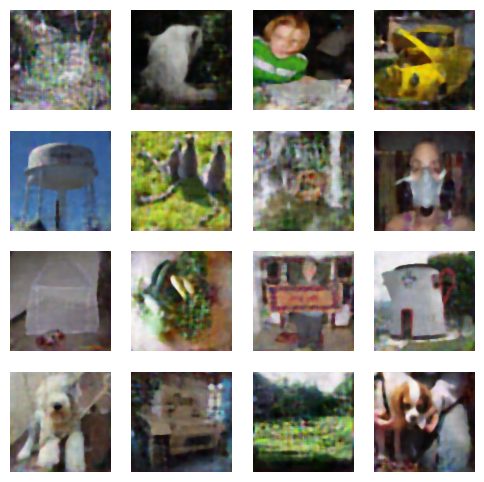

In [5]:
model = get_resnet18().to(device)
loss_func = torch.nn.CrossEntropyLoss()
data, label = next(loader_iter)
data, label = data.to(device), label.to(device)
client_grads = get_client_gradient(data, label, model, torch.nn.CrossEntropyLoss())
client_grads = [grad.clone() for grad in client_grads]
print(f"True Data:")
plot_images(data)

data = upscale(data)
best_ones_PSNR = torch.zeros_like(data)
best_ones_SSIM = torch.zeros_like(data)
best_ones_LPIPS = torch.zeros_like(data)
psnrs = []

for _ in range(5): # restart for better attack performance.
    recovered_images = FedLeak(client_grads, label, model, combine_loss, device=device)
    psnr = compute_psnr(data, recovered_images, False).mean().item()
    psnrs.append(psnr)
    best_ones_PSNR = update_best_ones(best_ones_PSNR, data, recovered_images, "PSNR")

print_psnrs(psnrs)
plot_images(best_ones_PSNR)

#### ⭕ 3.3 Times 3

True Data:


<Figure size 400x300 with 0 Axes>

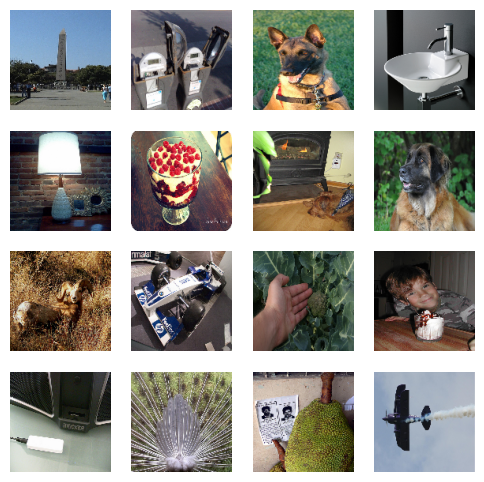

| It: 1 | Loss: -5.2341 | Time:   0.34s |


| It: 1001 | Loss: -60.8528 | Time: 352.23s |


| It: 2001 | Loss: -61.5220 | Time: 351.59s |


| It: 3001 | Loss: -61.6974 | Time: 352.20s |


| It: 4001 | Loss: -61.7817 | Time: 349.49s |


| It: 5001 | Loss: -61.8451 | Time: 352.60s |


| It: 6001 | Loss: -61.8867 | Time: 352.11s |


| It: 7001 | Loss: -61.9184 | Time: 351.64s |


| It: 8001 | Loss: -61.9366 | Time: 352.07s |


| It: 9001 | Loss: -61.9452 | Time: 352.44s |


| It: 1 | Loss: -3.6711 | Time:   0.38s |


| It: 1001 | Loss: -60.8025 | Time: 351.66s |


| It: 2001 | Loss: -61.4913 | Time: 351.14s |


| It: 3001 | Loss: -61.6958 | Time: 354.26s |


| It: 4001 | Loss: -61.7777 | Time: 349.27s |


| It: 5001 | Loss: -61.8440 | Time: 352.98s |


| It: 6001 | Loss: -61.8884 | Time: 353.50s |


| It: 7001 | Loss: -61.9186 | Time: 346.33s |


| It: 8001 | Loss: -61.9368 | Time: 348.11s |


| It: 9001 | Loss: -61.9455 | Time: 351.57s |


| It: 1 | Loss: -8.4163 | Time:   0.44s |


| It: 1001 | Loss: -60.8989 | Time: 352.48s |


| It: 2001 | Loss: -61.5496 | Time: 343.10s |


| It: 3001 | Loss: -61.7162 | Time: 354.39s |


| It: 4001 | Loss: -61.7966 | Time: 350.83s |


| It: 5001 | Loss: -61.8511 | Time: 352.16s |


| It: 6001 | Loss: -61.8914 | Time: 350.20s |


| It: 7001 | Loss: -61.9228 | Time: 351.86s |


| It: 8001 | Loss: -61.9410 | Time: 350.84s |


| It: 9001 | Loss: -61.9494 | Time: 350.58s |


| It: 1 | Loss: -13.7034 | Time:   0.38s |


| It: 1001 | Loss: -60.9112 | Time: 347.38s |


| It: 2001 | Loss: -61.5156 | Time: 351.02s |


| It: 3001 | Loss: -61.6937 | Time: 350.56s |


| It: 4001 | Loss: -61.7921 | Time: 350.28s |


| It: 5001 | Loss: -61.8472 | Time: 350.70s |


| It: 6001 | Loss: -61.8890 | Time: 352.24s |


| It: 7001 | Loss: -61.9198 | Time: 353.99s |


| It: 8001 | Loss: -61.9385 | Time: 350.17s |


| It: 9001 | Loss: -61.9468 | Time: 351.16s |


| It: 1 | Loss: -6.1620 | Time:   0.36s |


| It: 1001 | Loss: -60.8365 | Time: 352.72s |


| It: 2001 | Loss: -61.5279 | Time: 351.72s |


| It: 3001 | Loss: -61.7138 | Time: 352.22s |


| It: 4001 | Loss: -61.7940 | Time: 354.21s |


| It: 5001 | Loss: -61.8530 | Time: 347.75s |


| It: 6001 | Loss: -61.8953 | Time: 352.50s |


| It: 7001 | Loss: -61.9241 | Time: 350.63s |


| It: 8001 | Loss: -61.9422 | Time: 352.03s |


| It: 9001 | Loss: -61.9502 | Time: 350.82s |


BEST PSNR: 20.5121
MEDIAN PSNR: 19.9537
ALL PSNR: [19.7738, 19.8143, 19.3263, 20.3422, 20.3422]


<Figure size 400x300 with 0 Axes>

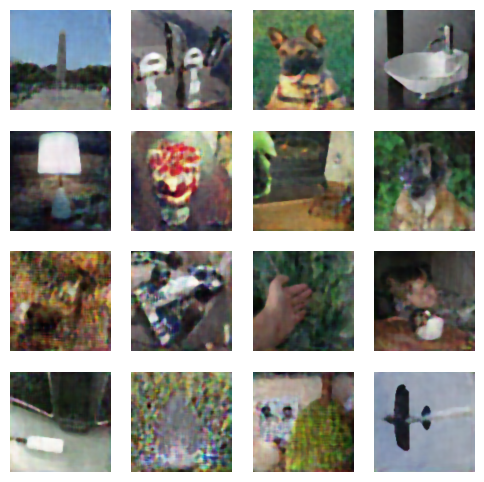

In [6]:
model = get_resnet18().to(device)
loss_func = torch.nn.CrossEntropyLoss()
data, label = next(loader_iter)
data, label = data.to(device), label.to(device)
client_grads = get_client_gradient(data, label, model, torch.nn.CrossEntropyLoss())
client_grads = [grad.clone() for grad in client_grads]
print(f"True Data:")
plot_images(data)

data = upscale(data)
best_ones_PSNR = torch.zeros_like(data)
best_ones_SSIM = torch.zeros_like(data)
best_ones_LPIPS = torch.zeros_like(data)
psnrs = []

for _ in range(5): # restart for better attack performance.
    recovered_images = FedLeak(client_grads, label, model, combine_loss, device=device)
    psnr = compute_psnr(data, recovered_images, False).mean().item()
    psnrs.append(psnr)
    best_ones_PSNR = update_best_ones(best_ones_PSNR, data, recovered_images, "PSNR")

print_psnrs(psnrs)
plot_images(best_ones_PSNR)

#### ⭕ 3.4 Times 4

True Data:


<Figure size 400x300 with 0 Axes>

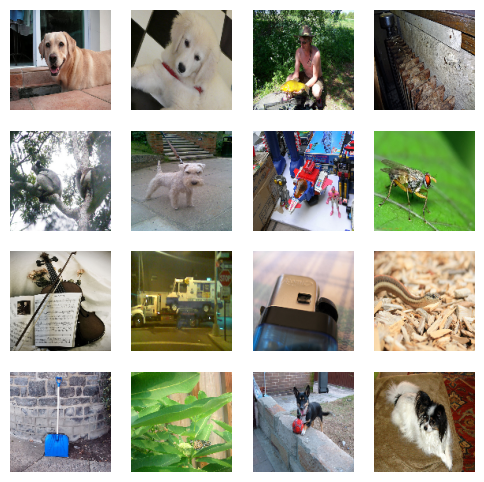

| It: 1 | Loss: -5.6984 | Time:   0.35s |


| It: 1001 | Loss: -61.3278 | Time: 364.98s |


| It: 2001 | Loss: -61.7144 | Time: 369.14s |


| It: 3001 | Loss: -61.8196 | Time: 367.70s |


| It: 4001 | Loss: -61.8721 | Time: 367.36s |


| It: 5001 | Loss: -61.9075 | Time: 366.56s |


| It: 6001 | Loss: -61.9335 | Time: 366.09s |


| It: 7001 | Loss: -61.9520 | Time: 367.71s |


| It: 8001 | Loss: -61.9632 | Time: 364.04s |


| It: 9001 | Loss: -61.9683 | Time: 361.05s |


| It: 1 | Loss: -3.3433 | Time:   0.37s |


| It: 1001 | Loss: -61.2218 | Time: 360.51s |


| It: 2001 | Loss: -61.6796 | Time: 359.87s |


| It: 3001 | Loss: -61.8101 | Time: 361.88s |


| It: 4001 | Loss: -61.8614 | Time: 360.95s |


| It: 5001 | Loss: -61.9018 | Time: 362.50s |


| It: 6001 | Loss: -61.9289 | Time: 362.91s |


| It: 7001 | Loss: -61.9484 | Time: 361.46s |


| It: 8001 | Loss: -61.9611 | Time: 362.44s |


| It: 9001 | Loss: -61.9664 | Time: 363.93s |


| It: 1 | Loss: -4.4228 | Time:   0.37s |


| It: 1001 | Loss: -61.2413 | Time: 365.59s |


| It: 2001 | Loss: -61.6901 | Time: 363.05s |


| It: 3001 | Loss: -61.8012 | Time: 363.49s |


| It: 4001 | Loss: -61.8657 | Time: 361.75s |


| It: 5001 | Loss: -61.9009 | Time: 361.71s |


| It: 6001 | Loss: -61.9303 | Time: 363.05s |


| It: 7001 | Loss: -61.9494 | Time: 363.73s |


| It: 8001 | Loss: -61.9615 | Time: 359.89s |


| It: 9001 | Loss: -61.9670 | Time: 363.26s |


| It: 1 | Loss: -16.8573 | Time:   0.37s |


| It: 1001 | Loss: -61.2431 | Time: 356.37s |


| It: 2001 | Loss: -61.7053 | Time: 353.05s |


| It: 3001 | Loss: -61.8160 | Time: 354.46s |


| It: 4001 | Loss: -61.8676 | Time: 358.84s |


| It: 5001 | Loss: -61.9046 | Time: 355.31s |


| It: 6001 | Loss: -61.9320 | Time: 359.50s |


| It: 7001 | Loss: -61.9514 | Time: 358.03s |


| It: 8001 | Loss: -61.9636 | Time: 356.54s |


| It: 9001 | Loss: -61.9685 | Time: 362.29s |


| It: 1 | Loss: -12.9561 | Time:   0.37s |


| It: 1001 | Loss: -61.3355 | Time: 361.12s |


| It: 2001 | Loss: -61.7227 | Time: 358.53s |


| It: 3001 | Loss: -61.8183 | Time: 360.26s |


| It: 4001 | Loss: -61.8698 | Time: 360.88s |


| It: 5001 | Loss: -61.9057 | Time: 359.50s |


| It: 6001 | Loss: -61.9339 | Time: 354.36s |


| It: 7001 | Loss: -61.9523 | Time: 358.95s |


| It: 8001 | Loss: -61.9634 | Time: 359.75s |


| It: 9001 | Loss: -61.9688 | Time: 361.18s |


BEST PSNR: 20.2550
MEDIAN PSNR: 19.7187
ALL PSNR: [18.6801, 19.8188, 20.2550, 19.8071, 19.8071]


<Figure size 400x300 with 0 Axes>

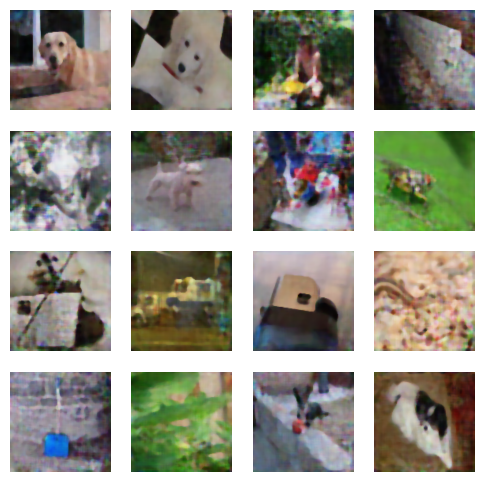

In [7]:
model = get_resnet18().to(device)
loss_func = torch.nn.CrossEntropyLoss()
data, label = next(loader_iter)
data, label = data.to(device), label.to(device)
client_grads = get_client_gradient(data, label, model, torch.nn.CrossEntropyLoss())
client_grads = [grad.clone() for grad in client_grads]
print(f"True Data:")
plot_images(data)

data = upscale(data)
best_ones_PSNR = torch.zeros_like(data)
best_ones_SSIM = torch.zeros_like(data)
best_ones_LPIPS = torch.zeros_like(data)
psnrs = []

for _ in range(5): # restart for better attack performance.
    recovered_images = FedLeak(client_grads, label, model, combine_loss, device=device)
    psnr = compute_psnr(data, recovered_images, False).mean().item()
    psnrs.append(psnr)
    best_ones_PSNR = update_best_ones(best_ones_PSNR, data, recovered_images, "PSNR")

print_psnrs(psnrs)
plot_images(best_ones_PSNR)

#### ⭕ 3.5 Times 5

True Data:


<Figure size 400x300 with 0 Axes>

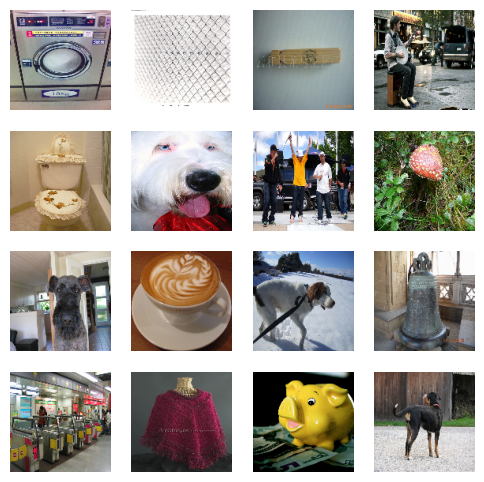

| It: 1 | Loss: -7.5674 | Time:   0.35s |


| It: 1001 | Loss: -60.8565 | Time: 360.77s |


| It: 2001 | Loss: -61.6033 | Time: 360.90s |


| It: 3001 | Loss: -61.7647 | Time: 357.85s |


| It: 4001 | Loss: -61.8341 | Time: 360.65s |


| It: 5001 | Loss: -61.8840 | Time: 361.89s |


| It: 6001 | Loss: -61.9141 | Time: 359.57s |


| It: 7001 | Loss: -61.9391 | Time: 359.96s |


| It: 8001 | Loss: -61.9526 | Time: 357.34s |


| It: 9001 | Loss: -61.9590 | Time: 357.78s |


| It: 1 | Loss: -13.0541 | Time:   0.37s |


| It: 1001 | Loss: -61.1444 | Time: 362.60s |


| It: 2001 | Loss: -61.6615 | Time: 361.29s |


| It: 3001 | Loss: -61.7884 | Time: 361.38s |


| It: 4001 | Loss: -61.8468 | Time: 357.88s |


| It: 5001 | Loss: -61.8893 | Time: 361.45s |


| It: 6001 | Loss: -61.9211 | Time: 360.92s |


| It: 7001 | Loss: -61.9417 | Time: 360.38s |


| It: 8001 | Loss: -61.9555 | Time: 365.19s |


| It: 9001 | Loss: -61.9617 | Time: 361.64s |


| It: 1 | Loss: -11.8654 | Time:   0.38s |


| It: 1001 | Loss: -61.0703 | Time: 360.42s |


| It: 2001 | Loss: -61.6544 | Time: 359.63s |


| It: 3001 | Loss: -61.7860 | Time: 357.45s |


| It: 4001 | Loss: -61.8428 | Time: 354.28s |


| It: 5001 | Loss: -61.8868 | Time: 358.31s |


| It: 6001 | Loss: -61.9191 | Time: 360.15s |


| It: 7001 | Loss: -61.9411 | Time: 359.22s |


| It: 8001 | Loss: -61.9541 | Time: 360.39s |


| It: 9001 | Loss: -61.9607 | Time: 359.52s |


| It: 1 | Loss: -8.7221 | Time:   0.37s |


| It: 1001 | Loss: -60.9266 | Time: 359.74s |


| It: 2001 | Loss: -61.6462 | Time: 358.45s |


| It: 3001 | Loss: -61.7720 | Time: 360.56s |


| It: 4001 | Loss: -61.8359 | Time: 362.33s |


| It: 5001 | Loss: -61.8847 | Time: 362.94s |


| It: 6001 | Loss: -61.9155 | Time: 361.11s |


| It: 7001 | Loss: -61.9385 | Time: 361.97s |


| It: 8001 | Loss: -61.9520 | Time: 360.76s |


| It: 9001 | Loss: -61.9583 | Time: 360.30s |


| It: 1 | Loss: -8.9162 | Time:   0.35s |


| It: 1001 | Loss: -61.2409 | Time: 362.32s |


| It: 2001 | Loss: -61.6920 | Time: 363.38s |


| It: 3001 | Loss: -61.8027 | Time: 361.26s |


| It: 4001 | Loss: -61.8634 | Time: 357.89s |


| It: 5001 | Loss: -61.8999 | Time: 349.15s |


| It: 6001 | Loss: -61.9278 | Time: 360.64s |


| It: 7001 | Loss: -61.9475 | Time: 360.33s |


| It: 8001 | Loss: -61.9595 | Time: 360.17s |


| It: 9001 | Loss: -61.9651 | Time: 361.95s |


BEST PSNR: 19.7080
MEDIAN PSNR: 18.9862
ALL PSNR: [18.9129, 18.6427, 18.7667, 18.9008, 18.9008]


<Figure size 400x300 with 0 Axes>

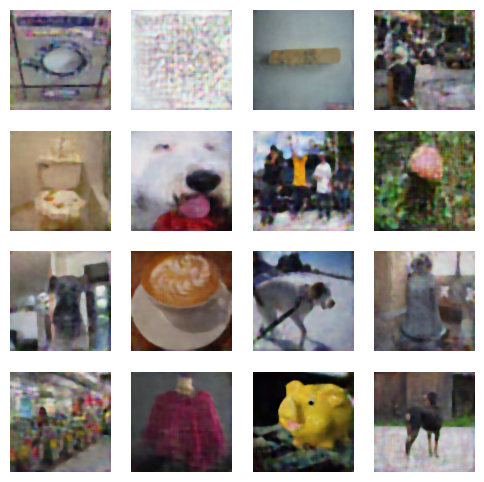

In [8]:
model = get_resnet18().to(device)
loss_func = torch.nn.CrossEntropyLoss()
data, label = next(loader_iter)
data, label = data.to(device), label.to(device)
client_grads = get_client_gradient(data, label, model, torch.nn.CrossEntropyLoss())
client_grads = [grad.clone() for grad in client_grads]
print(f"True Data:")
plot_images(data)

data = upscale(data)
best_ones_PSNR = torch.zeros_like(data)
best_ones_SSIM = torch.zeros_like(data)
best_ones_LPIPS = torch.zeros_like(data)
psnrs = []

for _ in range(5): # restart for better attack performance.
    recovered_images = FedLeak(client_grads, label, model, combine_loss, device=device)
    psnr = compute_psnr(data, recovered_images, False).mean().item()
    psnrs.append(psnr)
    best_ones_PSNR = update_best_ones(best_ones_PSNR, data, recovered_images, "PSNR")

print_psnrs(psnrs)
plot_images(best_ones_PSNR)